While python has built-in functions to solve ODEs, understanding how an ODE solver actually works and when it might fail is crucial to understand results obtained with these functions. In this section, we will implement standard time stepping methods, and investigate their properties.

A first important type of ODE is *Initial Value Problems* (IVP). In an IVP, we are intereted in solving equations of the form

$\frac{df}{dt}=s(f,t)$

where $f(t)$ may be a scalar or a vector, with initial condition $f(t_0)=f_0$. We note that this method is more general than it seems. If we had a higher-order ODE, e.g.

$\frac{d^2 g}{dt^2} = s(g,\frac{dg}{dt},t)$

we could define the vector $(u,v)$ with $u=g$ and $v=\frac{dg}{dt}$ and get

$\frac{du}{dt} = v$

$\frac{dv}{dt} = s(u,v,t)$

which has the same form as above, if we take $f=(u,v)$.

The simplest method to solve such a problem numerically is the *forward Euler* algorithm, where we approximate

$\frac{df}{dt} = \frac{f(t+\Delta t)-f(t)}{\Delta t}$

This allows us to write

$f(t+\Delta t) = f(t) + s(f,t) \Delta t$

Choosing a time step $\Delta t$, we can use this formula recursively to calculate $f(t_0+\Delta t)$, $f(t_0+2\Delta t)$,...

**Question 1**

Write code that uses the Forward Euler method to solve

$\frac{df}{dt} = -2 f$

with $f(0)=3.5$, and plot the result in the time interval $[0,1]$. Try using $\Delta t = 1, 0.1, 0.01, 0.001$ and compare your solution to the analytical result

$f_{\rm true} = 3.5 e^{-2t}$

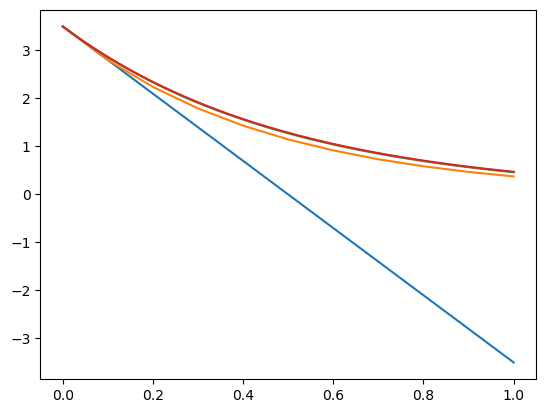

In [3]:
import numpy
import matplotlib.pyplot as plt

def eulers_method(f_0, t_step):
    f = numpy.array([f_0])
    t = numpy.arange(0, 1 + t_step, t_step)
    for i in range(1, len(t)):
        f = numpy.append(f, (f[i - 1] - (2 * f[i - 1] * t_step)))
    return f, t

f1, t1 = eulers_method(3.5, 1)
f2, t2 = eulers_method(3.5, 0.1)
f3, t3 = eulers_method(3.5, 0.01)
f4, t4 = eulers_method(3.5, 0.001)

plt.plot(t1, f1)
plt.plot(t2, f2)
plt.plot(t3, f3)
plt.plot(t4, f4)

The forward Euler method is fairly inaccurate in practice: its error scales linearly with $\Delta t$. Higher-order methods are derived to have errors scaling as $(\Delta t)^n$, with $n$ the order of the method. A common example of higher order methods is the Runge-Kutta family of algorithms. A second-order Runge-Kutta (or mid-point method) follows the algorithm

$f_1 = f(t) + s(f,t) \frac{\Delta t}{2}$

$f(t+\Delta t) = f(t) + s(f_1,t) \Delta t$

to take a time step $\Delta t$. It requires two evaluations of $s$, but for sufficiently small $\Delta t$ this cost is more than offset by the higher order of convergence of the method.

**Question 2**

Repeat question 1, but with the mid-point method.

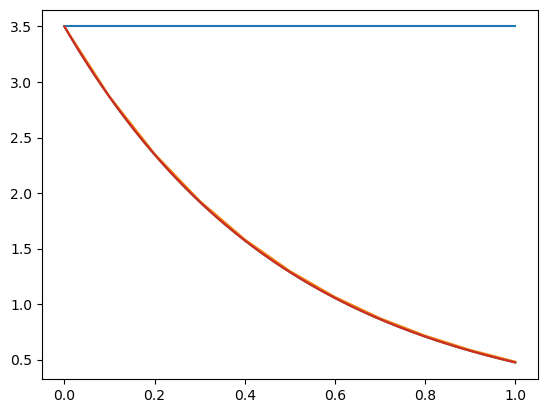

In [5]:
def runge_kutta(f_0, t_step):
    f = numpy.array([f_0])
    t = numpy.arange(0, 1 + t_step, t_step)
    for i in range(1, len(t)):
        f_1 = f[i - 1] - (2 * f[i - 1] * (t_step / 2))
        f = numpy.append(f, f[i - 1] - (2 * f_1 * t_step))
    return f, t

frk1, trk1 = runge_kutta(3.5, 1)
frk2, trk2 = runge_kutta(3.5, 0.1)
frk3, trk3 = runge_kutta(3.5, 0.01)
frk4, trk4 = runge_kutta(3.5, 0.001)

plt.plot(trk1, frk1)
plt.plot(trk2, frk2)
plt.plot(trk3, frk3)
plt.plot(trk4, frk4)

**Question 3**

Now, let us investigate a higher order problem. Consider the equations for a ballistic trajectory with non-zero velocity,

$\frac{d^2 x}{dt^2} = - \nu \frac{dx}{dt}$

$\frac{d^2 z}{dt^2} = - \nu \frac{dz}{dt} - g$

with $\nu$ the dynamical viscosity and $g$ the gravitational acceleration. Write code allowing you to solve this problem for arbitray initial conditions and values of $(g,\nu)$. The code should terminate when the projectile hits the ground, and return the time at which this happens.

In [7]:
import math

def ballistic(g, v, vel_0, thet, z0, t_step):
    dx_dt0 = vel_0 * math.cos(thet)
    dz_dt0 = vel_0 * math.sin(thet)
    dz_dt = numpy.array([dz_dt0])
    dx_dt = numpy.array([dx_dt0])
    z = z0
    t = 0
    i = 1
    while z > 0:
        dx_1 = dx_dt[i - 1] + (-v * dx_dt[i - 1] * (t_step / 2))
        dx_dt = numpy.append(dx_dt, dx_dt[i - 1] + (-v * dx_1 * t_step))
        
        dz_1 = dz_dt[i - 1] + ((-v * dz_dt[i - 1] - g) * (t_step / 2))
        dz_dt = numpy.append(dz_dt, dz_dt[i - 1] + ((-v * dz_1 - g) * t_step))
        
        z += dz_1 * t_step
        t += t_step
        i += 1
    return t

print("zero drag, zero initial velocity:", ballistic(9.8, 0, 0, 0, 10, 0.0001))

print("zero drag, initial velocity = 30 m/s, theta = 45 degrees:", ballistic(9.8, 0, 30, 0.785, 10, 0.0001))

print("viscosity = 5, initial velocity = 30 m/s, theta = 45 degrees:", ballistic(9.8, 5, 30, 0.785, 10, 0.0001))

zero drag, zero initial velocity: 1.428599999999859
zero drag, initial velocity = 30 m/s, theta = 45 degrees: 4.756600000002253
viscosity = 5, initial velocity = 30 m/s, theta = 45 degrees: 7.465799999995939


Some equations behave very poorly when using the standard time stepping methods described so far. One common issue is when the source term $s$ is "too large" (when derivatives of $s$ with respect to the evolved variables are large compared to $1/\Delta t$). We will now investigate how to deal with this issue.

**Question 4**

Try to solve the equation

$\frac{df}{dt} = 10^6 (1-f)$

for $f(0)=2.0$ with one of the methods described in questions 1-3. The correct solution is

$f_{\rm true} = (1-e^{-10^6 (t-t_0)}) + f(t_0) e^{-10^6 (t-t_0)}.$

(This type of equation is common for example in radiation transport). You will find that unless you use a very small $\Delta t$, your solution  rapidly blows up.

/var/folders/cy/ymbv43x565b8ghrkp_kpw1nw0000gn/T/ipykernel_35011/3409565920.py:6: RuntimeWarning: overflow encountered in scalar multiply
  f = numpy.append(f, f[i - 1] + (10 ** 6 * (1 - f_1) * t_step))
/var/folders/cy/ymbv43x565b8ghrkp_kpw1nw0000gn/T/ipykernel_35011/3409565920.py:5: RuntimeWarning: invalid value encountered in scalar add
  f_1 = f[i - 1] + (10 ** 6 * (1 - f[i - 1]) * (t_step / 2))
/var/folders/cy/ymbv43x565b8ghrkp_kpw1nw0000gn/T/ipykernel_35011/3409565920.py:5: RuntimeWarning: overflow encountered in scalar multiply
  f_1 = f[i - 1] + (10 ** 6 * (1 - f[i - 1]) * (t_step / 2))


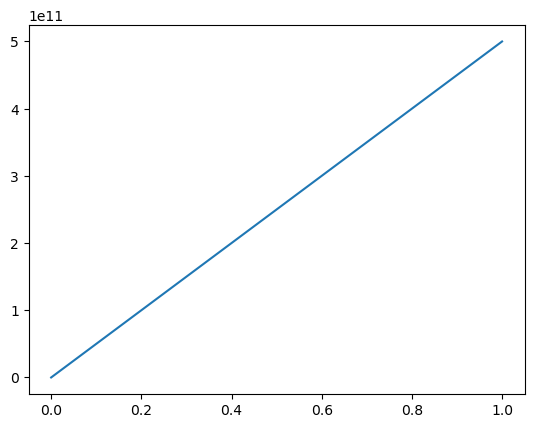

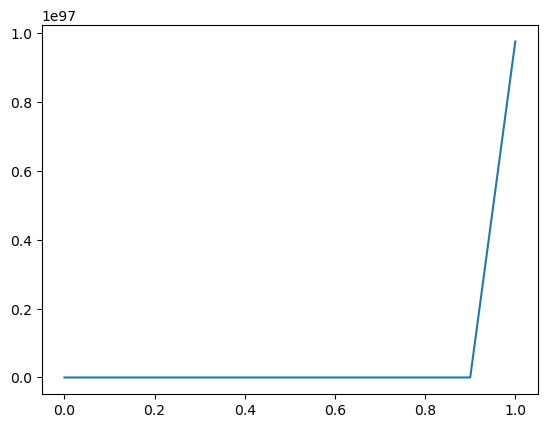

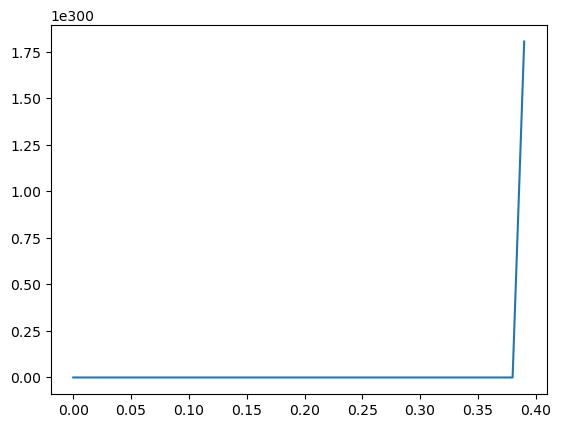

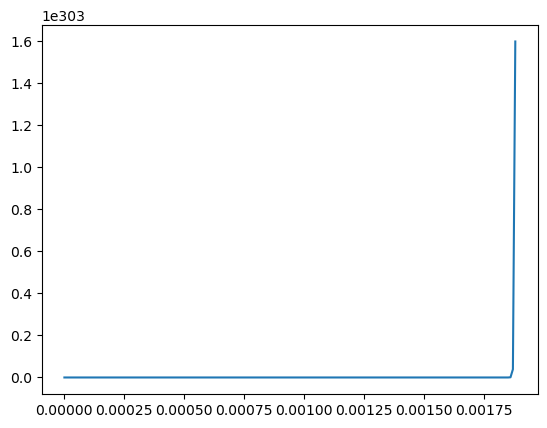

In [199]:
def runge_kutta_q4(f_0, t_step):
    f = numpy.array([f_0])
    t = numpy.arange(0, 1 + t_step, t_step)
    for i in range(1, len(t)):
        f_1 = f[i - 1] + (10 ** 6 * (1 - f[i - 1]) * (t_step / 2))
        f = numpy.append(f, f[i - 1] + (10 ** 6 * (1 - f_1) * t_step))
    return f, t

fq1, tq1 = runge_kutta_q4(2, 1)
fq2, tq2 = runge_kutta_q4(2, 0.1)
fq3, tq3 = runge_kutta_q4(2, 0.01)
fq4, tq4 = runge_kutta_q4(2, 0.00001)

plt.plot(tq1, fq1)
plt.figure()
plt.plot(tq2, fq2)
plt.figure()
plt.plot(tq3, fq3)
plt.figure()
plt.plot(tq4, fq4)

A potential solution is to use *implicit methods*. The general idea of an implicit method is to use $s(f,t)$ at the end of a time step when taking a time step. This of course makes our system of equations have a non-trivial dependence in $f(t+\Delta t)$. For example, the first-order method becomes

$f(t+\Delta t) - f(t) = s[f(t+\Delta t),t+\Delta t]\Delta t$

Solving this equation in general requires the use of a root-finding algorithm at each time step. For the problem of Question 4 (and any other problem linear in $f$), however, things are significantly easier. We have

$f(t+\Delta t) - f(t) = 10^6 [1-f(t+\Delta t)] \Delta t$

or

$f(t+\Delta t) = \frac{10^6 \Delta t+ f(t)}{1+10^6 \Delta t}$

**Question 5**

Use the implicit method descibed above to solve the problem from question 4, using $\Delta t = 1,0.1,0.01$. Compare your results to the true solution.

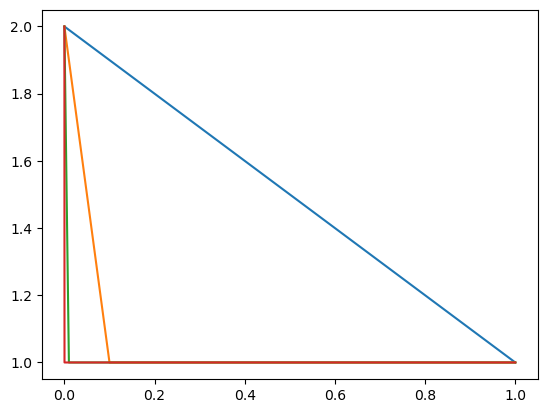

In [211]:
def implicit(f_0, t_step):
    f = numpy.array([f_0])
    t = numpy.arange(0, 1 + t_step, t_step)
    for i in range(1, len(t)):
        f = numpy.append(f, (10 ** 6 * t_step + f[i - 1]) / (1 + 10 ** 6 * t_step))
    return f, t

fimp1, timp1 = implicit(2, 1)
fimp2, timp2 = implicit(2, 0.1)
fimp3, timp3 = implicit(2, 0.01)
fimp4, timp4 = implicit(2, 0.00001)

plt.plot(timp1, fimp1)
plt.plot(timp2, fimp2)
plt.plot(timp3, fimp3)
plt.plot(timp4, fimp4)

Another common failure for ODE solvers, which we do not investigate here, is when $s$ goes to infinity. This may lead to the solution itself going to infinity (in which case the code should be stopped before this happens), but not necessarily: it is possible for the singularity to be integrable, i.e. for $\int dt s(t)$ to be finite. In that case, the singular point often has to be treated with a combination of analytical and numerical methods.

**Question 6**

For most practical application, it is easier to use python's built-in ODE solvers than to code your own method. To familiarize yourselves with these methods, use the odeint function from scipy to solve the problems of question 1 and 5. You may refer to the notebooks on github for example uses of odeint. Note that once you have a python setup to solve a system of differential equations using odeint, you can reuse it on any problems with simple modifications of the derivative function and initial conditions... as long as the system of equations is well-behaved!

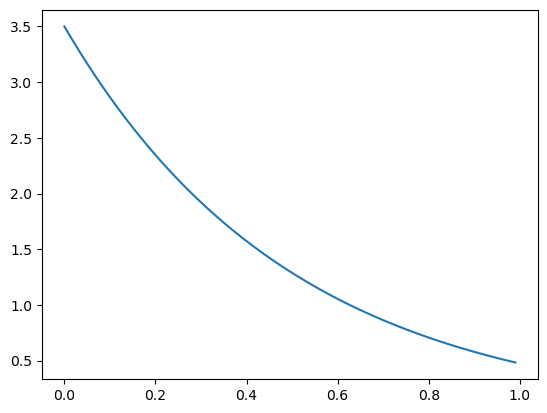

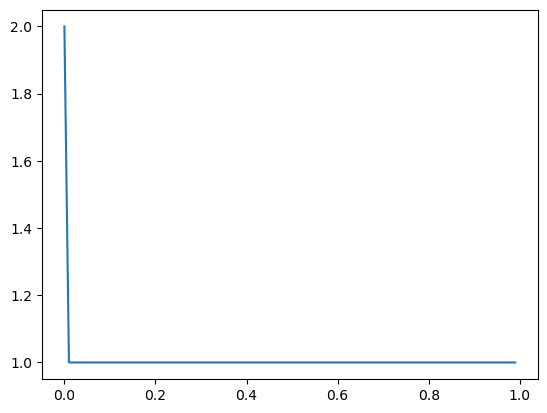

In [173]:
import scipy.integrate as integrate

# q1

def q1_func(f, t):
    df_dt = -2 * f
    return df_dt

t = numpy.arange(0, 1, 0.01)

sol1 = integrate.odeint(q1_func, 3.5, t)
plt.plot(t, sol1)

# q5

def q5_func(f, t):
    df_dt = 10 ** 6 * (1 - f)
    return df_dt
    
plt.figure()
sol2 = integrate.odeint(q5_func, 2.0, t)
plt.plot(t, sol2)